In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
plt.style.use('ggplot')

----
## INHOUD:

* [AD Conversie](#Analog_Digital_Conversion)
    * [Sampling](#Sampling)
    * [Quantization](#Quantization)
    
    
----    

------------
## Analog Digital Conversion

Two steps are mandatory in order to do digital processing on analog signals.
![Analog, discrete and digital signals](figures/analog_discrete_digital.png)

---
# Sampling, Aliasing en Nyquist:


### Nyquist (Folding) frequency: $$\dfrac{f_s}{2}$$
### Nyquist rate: $$f_s=2 f_{max}$$
### Nyquist interval: $$\left[-\dfrac{f_s}{2}, \dfrac{f_s}{2}\right]$$

### Nyquist condition: $$f_s \geq 2 f_{max}$$
----

In [3]:
def aliasingExample(fs=2.1,f1=1):

    #fs = 0.9
    T = 1/fs #sampling period

    tstart = 0
    tend = 6

    #t = np.linspace(0,8,801) #for the continuous time signals
    #n = np.linspace(tstart,tend)
    t = np.arange(tstart,tend,1./100) #time axis
    n = np.arange(tstart,tend*fs) #discrete time intervals 

    #f1 = 1 #analog frequency 1 pos=2> neg= <2
    f2 = np.mod(f1,fs) #analog frequency 2

    if f2>fs/2:
        f2 = f2-fs

    w1 = 2*np.pi*f1
    w2 = 2*np.pi*f2

    phi = -.1*np.pi

    def genSig(arg,type='sin'):
        if type == 'cos':
            return np.cos(arg)
        else:
            return np.sin(arg)

    y1 = genSig(w1*t+phi)
    y2 = genSig(w2*t+phi)    
    
    #print("Nyquist frequency {} Hz".format(fs/2))
    
    plt.figure(num=None, figsize=(14,12), dpi=120, facecolor='w', edgecolor='k')
    plt.plot(t,y1,'r', label=str(f1) + ' Hz', linewidth=3)
    plt.plot(t,y2,'b', label=str(f2) + ' Hz')

    plt.stem(n*T,genSig(w1*n*T+phi),linefmt='k-', markerfmt='ro', basefmt='r.')

    #plt.scatter(n,np.cos(w2*n*T),marker='.',color='blue',s=200) #digitaal 1.3Hz signaal
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude [au]')
    plt.legend(loc='best',fontsize='large')
    
#aliasingExample(fs=0.9,f1=1)

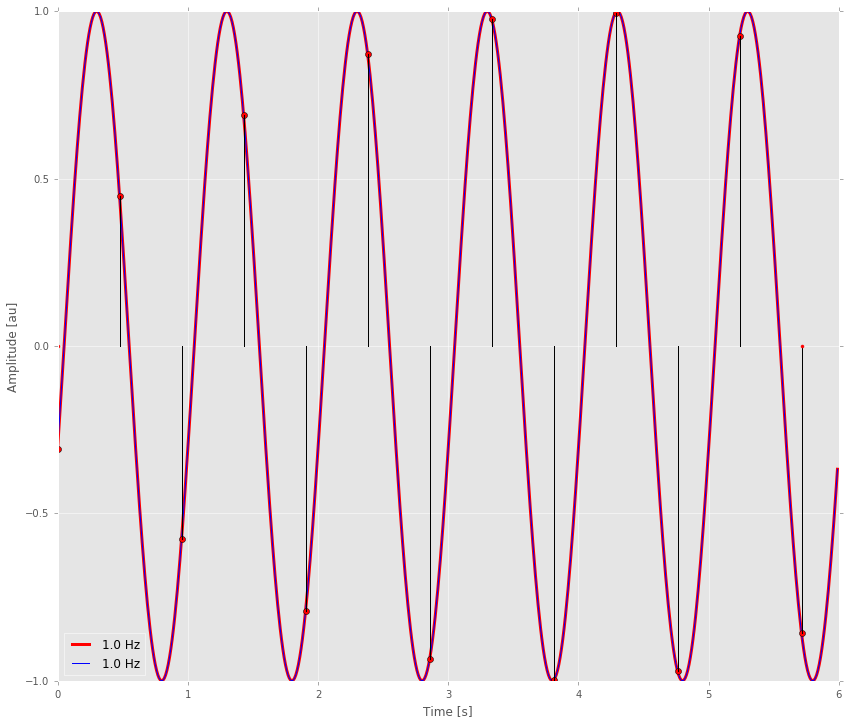

In [4]:
from ipywidgets import interactive

interactive(aliasingExample, fs=(0,3,0.02), f1 = (0,3,0.5))

---

# Quantization

### Supporting functions

In [5]:
def biquant(NoBits, Xmin, Xmax, x):
    # function pq = biquant(NoBits, Xmin, Xmax, value)
    # This routine is created for simulation of the bipolar quantizer.
    #
    # NoBits: number of bits used in quantization.
    # Xmax: overload value.
    # Xmin: minimum value
    # value: input to be quantized.
    # pq: output of the quantized value
    # I: coded integer index
    
    L = 2**NoBits; #Levels
    delta = (Xmax-Xmin)/L; #delta
    I = np.round((x-Xmin)/delta);
    
    if ( I == L):
        I = I-1

    if I < 0:
        I = 0

    pq = Xmin + I*delta;
    return pq

---

Het samplen zorgt voor een opdeling in de tijd. Kwantiseren is nodig om het signaal op te delen in de amplitude. Het aantal niveaus (levels) wordt bepaald door het aantal bits van de AD converter. 

Stel we hebben een 3 bits analoog naar digitaal (AD) converter, het aantal levels wat we dan verkrijgen is:

\begin{equation}
levels = 2^{n} = 2^3 = 8
\end{equation}

De resolutie (vaak in Volt uitgedrukt) wordt bepaald door de verhouding in het bereik van de AD converter en het aantal levels:

\begin{equation}
resolutie (Q) = \frac{bereik (R)}{levels} = \frac{2}{8} = 0.25~V
\end{equation}

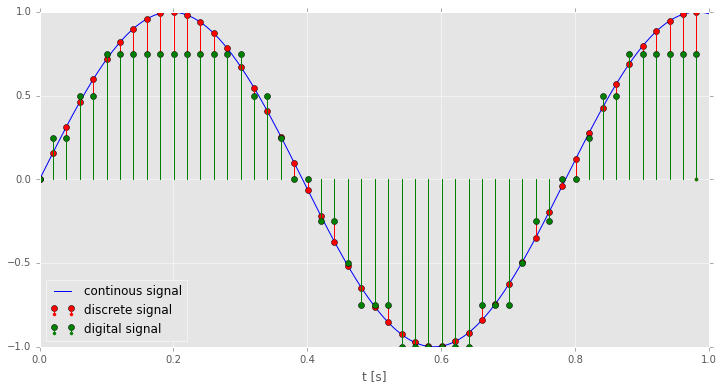

In [6]:
N = 1000  # length of signal

# generate signal
A = 1
f = 4
t = np.linspace(0,1,N)
x = A*np.sin(f*2*t)
t_discr = t[::20]
x_discr = x[::20]

nBits = 3
xQ = [biquant(nBits,-A,A,xi) for xi in x_discr]

# plot (quantized) signals
fig, ax1 = plt.subplots(figsize=(12, 6), dpi=120, facecolor='w', edgecolor='k')

ax1.plot(t,x, 'b', label=r'continous signal')
ax1.stem(t_discr,x_discr,label=r'discrete signal',linefmt='r-', markerfmt='ro', basefmt='r.')
ax1.stem(t_discr,xQ,label=r'digital signal',linefmt='g-', markerfmt='go', basefmt='g.')
ax1.set_xlabel('t [s]')
ax1.legend(loc=0)

plt.show()

----